**A Simple Finance Tracker**

Stemming from the glaring red balance in my bank account, I began to wonder: maybe I can teach a machine to make me money...

The answer is, probably not. But I still tried.

Here is a very simple data analysis and subsequent LSTM model to predict the close price of any given stock in the S&P500. Thanks to Fares Sayah for providing some of the ideas for this code and his notated notebooks.

First, we import our packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import tensorflow as tf
from datetime import datetime

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf

In [ ]:
msft = yf.Ticker("MSFT")

Firstly, we grab stock data using the *yfinance* package. I wanted to quickly visualize some of the data, such as displaying price of a stock over time.  

In [ ]:
# Stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-05-24,2080.500000,2108.000000,2025.199951,2082.000000,2082.000000,5146700,AMAZON
2022-05-25,2073.110107,2163.500000,2073.000000,2135.500000,2135.500000,4656000,AMAZON
2022-05-26,2159.399902,2253.310059,2149.070068,2221.550049,2221.550049,4650100,AMAZON
2022-05-27,2271.000000,2303.739990,2252.560059,2302.929932,2302.929932,4675800,AMAZON
2022-05-31,2325.600098,2439.889893,2313.500000,2404.189941,2404.189941,7211600,AMAZON


This is quite a dirty way to split up the data for the subplots. And there is defintely a better and more efficient way of doing it. But I was tired.

*Something to change for v2*

But below is a simple set of subplots looking at the close price over time:

In [ ]:
# Splitting into different dfs
grouped = df.groupby(df.company_name)
dfApple = grouped.get_group("APPLE")
dfGoogle = grouped.get_group("GOOGLE")
dfMicrosoft = grouped.get_group("MICROSOFT")
dfAmazon = grouped.get_group("AMAZON")

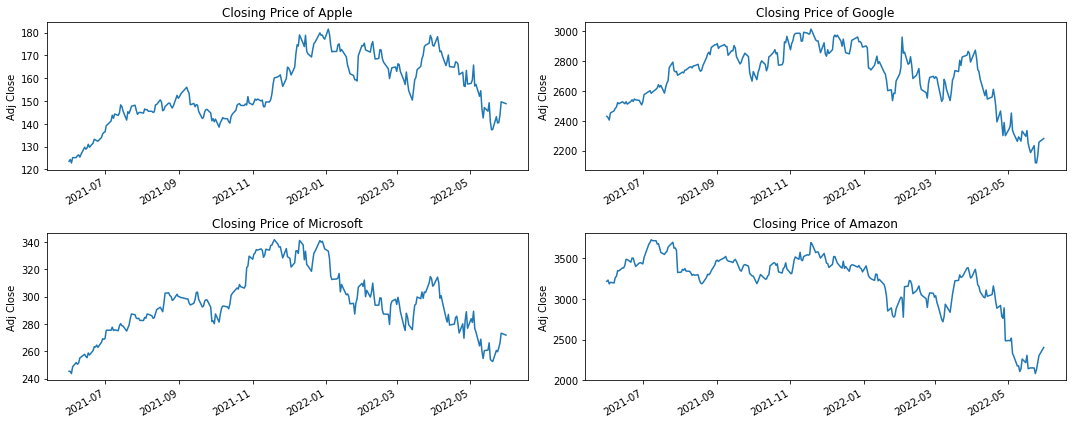

In [ ]:
# Plotting Adj Closes of 4 tech companies
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

plt.subplot(2,2,1)
dfApple["Adj Close"].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of Apple")

plt.subplot(2,2,2)
dfGoogle["Adj Close"].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of Google")

plt.subplot(2,2,3)
dfMicrosoft["Adj Close"].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of Microsoft")

plt.subplot(2,2,4)
dfAmazon["Adj Close"].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of Amazon")

plt.tight_layout()

Next, I wanted to look at a different metric: the daily volume traded of these same 4 companies. Are price and volume related in some way?

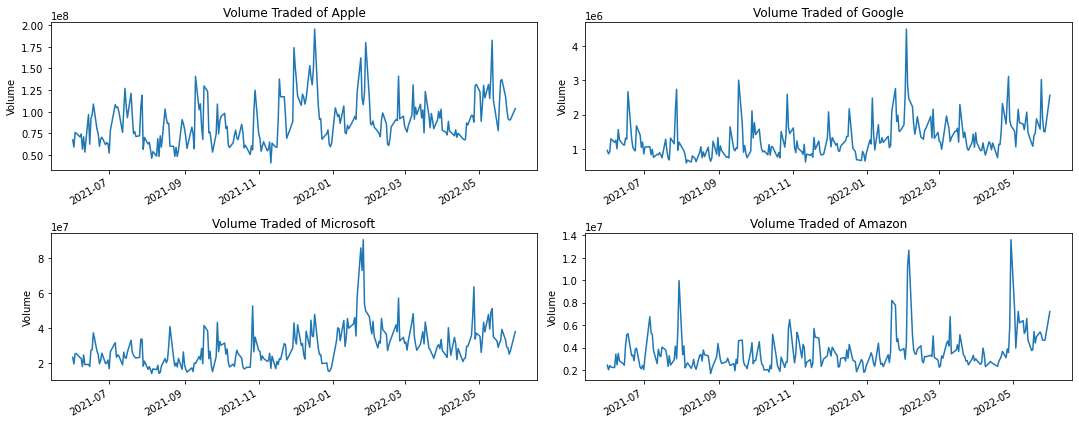

In [ ]:
# Plotting volume traded of 4 tech companies
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

plt.subplot(2,2,1)
dfApple["Volume"].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Volume Traded of Apple")

plt.subplot(2,2,2)
dfGoogle["Volume"].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Volume Traded of Google")

plt.subplot(2,2,3)
dfMicrosoft["Volume"].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Volume Traded of Microsoft")

plt.subplot(2,2,4)
dfAmazon["Volume"].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Volume Traded of Amazon")

plt.tight_layout()

Now let's begin to build a model to predict the future closing price for another stock: Tesla.

In [ ]:
# Get the stock quote
end = datetime.now()
start = '2012-01-01'
stock = "TSLA"

dfTeslaFull = globals()[stock] = yf.download(stock, start, end)

# Show the data
dfTeslaFull.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,5.788,5.900,5.530,5.616,5.616,4640500
2012-01-04,5.642,5.734,5.500,5.542,5.542,3150500
2012-01-05,5.552,5.586,5.370,5.424,5.424,5027500
2012-01-06,5.440,5.558,5.282,5.382,5.382,4931500
2012-01-09,5.400,5.498,5.224,5.450,5.450,4485000


In [ ]:
# Select only close price
teslaData = dfTeslaFull.filter(['Close'])

# Convert to a numpy array
teslaDSet = teslaData.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(teslaDSet) * .95 ))

This scaling could be wrong, as stocks do not have min/max bounds, but generally speaking scaling the data will improve the performance of the neural network.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(teslaDSet)

In [ ]:
# Create training set
train_data = scaled_data[0:int(training_data_len), :]

# Split into x train and y train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

This took a little while the first time I ran it.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2429/2429 [==============================] - 120s 48ms/step - loss: 0.0017


In [ ]:
# Test dataset
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = teslaDSet[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Model predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

And there we go.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


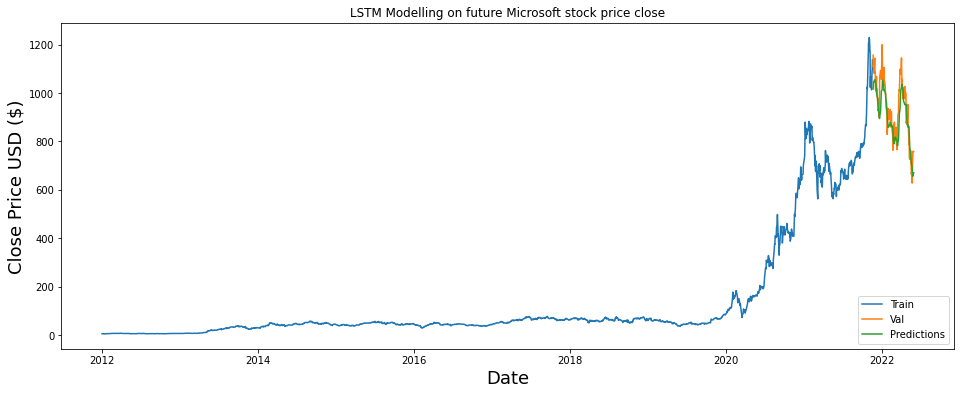

In [ ]:
# Plotting data
train = teslaData[:training_data_len]
valid = teslaData[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('LSTM Modelling on future Microsoft stock price close')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
print(valid)

                  Close  Predictions
Date                                
2021-11-22  1156.869995  1017.218323
2021-11-23  1109.030029  1035.244751
2021-11-24  1116.000000  1044.569092
2021-11-26  1081.920044  1049.941284
2021-11-29  1136.989990  1047.394897
...                 ...          ...
2022-05-24   628.159973   684.921143
2022-05-25   658.799988   667.632446
2022-05-26   707.729980   655.992004
2022-05-27   759.630005   656.371094
2022-05-31   758.260010   670.294373

[131 rows x 2 columns]
